### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations>=0.3.0 --user 
!pip install -U --pre segmentation-models --user
#This installation command is to resolve issues with respect to efficient not being found in the initila build of segmentation modle sm 
!pip install -U git+https://github.com/qubvel/segmentation_models
#uPGRADE SCKITI IMAGE
!pip install --upgrade scikit-image
#RESTART THE KERNEL POST INSTALLATION
#This is to resolve the dependency issues with skimage. 
!pip install numpy==1.17

  Cloning https://github.com/qubvel/segmentation_models to c:\users\aczd087\appdata\local\temp\pip-req-build-1fu51y7h
  Stored in directory: C:\Users\aczd087\AppData\Local\Temp\pip-ephem-wheel-cache-kw9ch7a3\wheels\49\cf\46\cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models
  Found existing installation: segmentation-models 1.0.0
    Uninstalling segmentation-models-1.0.0:
      Successfully uninstalled segmentation-models-1.0.0


  Found existing installation: scikit-image 0.14.2
    Uninstalling scikit-image-0.14.2:
      Successfully uninstalled scikit-image-0.14.2
  Found existing installation: numpy 1.16.2
    Uninstalling numpy-1.16.2:
      Successfully uninstalled numpy-1.16.2


tensorflow 1.14.0 requires google-pasta>=0.1.6, which is not installed.
tables 3.5.1 requires mock>=2.0, which is not installed.
tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 40.8.0 which is incompatible.
Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\anaconda3\\lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
#RESTART THE KERNEL POST INSTALLATION of cell above
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from sklearn.model_selection import train_test_split
import glob
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import imageio
import albumentations as A

C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [ ]:
#Confirmation that GPU is in working order. 
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print(tf.test.gpu_device_name())

with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

# Loading dataset

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [3]:
pwd

'/home/ec2-user/SageMaker/Masters-Thesis-UNet-repository/jupyter_notebooks'

In [16]:
os.path.join(DATA_DIR, 'source')

'/home/ec2-user/SageMaker/data/NIFTI_MR_512x512_png_256grey_lvl/t1dual_inphase/source'

In [3]:
TRAIN_DATA_DIR =r'/home/ec2-user/SageMaker/data/train_data/250/NIFTI_MR_512x512_png_256grey_lvl/t1dual_inphase'
VALID_DATA_DIR=r'/home/ec2-user/SageMaker/data/valid_data/1_pat_no_32/NIFTI_MR_512x512_png_256grey_lvl/t1dual_inphase'
TEST_DATA_DIR=r'/home/ec2-user/SageMaker/data/valid_data/1_pat_no_32/NIFTI_MR_512x512_png_256grey_lvl/t1dual_inphase'



In [14]:
trl_lst=glob.glob(x_train_dir)

In [21]:
trl_lst

['/home/ec2-user/SageMaker/data/train_data/250/NIFTI_MR_512x512_png_256grey_lvl/t1dual_inphase/source']

In [ ]:
trl_img=imageio.imread(trl_lst[0])

trl_img.shape

In [4]:
x_train_dir = os.path.join(TRAIN_DATA_DIR, 'source')
y_train_dir = os.path.join(TRAIN_DATA_DIR, 'ground')

x_valid_dir = os.path.join(VALID_DATA_DIR, 'source')
y_valid_dir = os.path.join(VALID_DATA_DIR, 'ground')

x_test_dir = os.path.join(TEST_DATA_DIR, 'source')
y_test_dir = os.path.join(TEST_DATA_DIR, 'ground')

# Dataloader and utility functions 

In [5]:
# helper function for data visualization
def visualize(figdim=(30,30),**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=figdim)
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = {'background':0,'liver':63,'r_kidney':126,'l_kidney':189,'spleen':252}
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES[cls.lower()] for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = imageio.imread(self.images_fps[i])#cv2.imread(self.images_fps[i])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image=np.expand_dims(image,axis=2)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

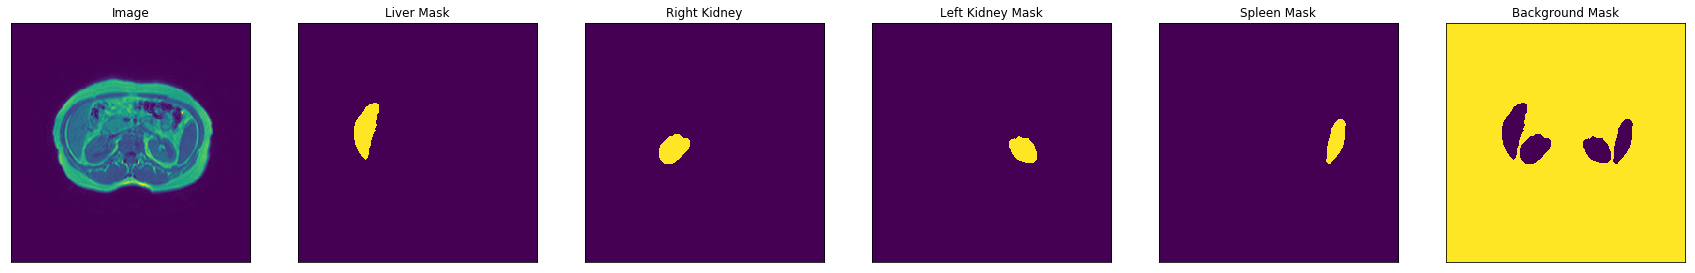

In [6]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['liver','r_kidney','l_kidney','spleen'])

image, mask = dataset[5] # get some sample
visualize(
    image=np.squeeze(image,axis=2), 
    liver_mask=mask[..., 0].squeeze(),
    right_kidney=mask[..., 1].squeeze(),
    left_kidney_mask=mask[..., 2].squeeze(),
    spleen_mask=mask[..., 3].squeeze(),
    background_mask=mask[..., 4].squeeze()
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.


In [7]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

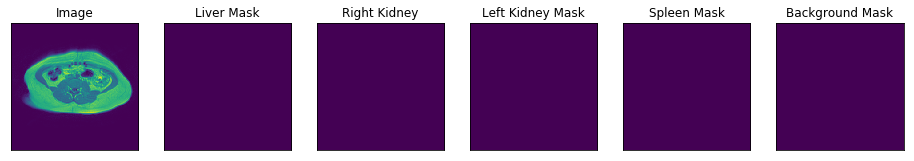

In [32]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, 
                  classes=['liver','r_kidney','l_kidney','spleen'])

image, mask = dataset[12] # get some sample
visualize(
    image=np.squeeze(image,axis=2),
    liver_mask=mask[..., 0].squeeze(),
    right_kidney=mask[..., 1].squeeze(),
    left_kidney_mask=mask[..., 2].squeeze(),
    spleen_mask=mask[..., 3].squeeze(),
    background_mask=mask[..., 4].squeeze()
)

In [ ]:
dataset[5]

# Segmentation model training

In [20]:
import segmentation_models as sm

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

In [21]:
import datetime

In [42]:
BACKBONE = 'resnet101'#'efficientnetb3'densenet121
BATCH_SIZE = 3
CLASSES = ['l_kidney','liver','r_kidney','spleen']#
class_weights='yes'
opt='adam'
loss_func='categorical_cross_entropy'
grey_lvl=256
samp_size=250
str_time=str(datetime.datetime.now())[:10]
img_type='t1dual_inphase'
batch_size=3
orgs='all_orgs'

Model_name=img_type+'_'+orgs+'_grey_lvl_'+str(grey_lvl)+'_optm_'+opt+'_loss_'+loss_func+'_trn_samp_sz_'+str(samp_size)+'_btch_sz_'+str(batch_size)+'_time_'+str_time

#Model_name='t1dual_inphase_all_orgs_256greylvl_cls_wghts_yes_adam_opt_Btch_sze_3_softmax_dice_loss_12Oct19'
LR = 0.0001
EPOCHS = 50
N=1
preprocess_input = sm.get_preprocessing(BACKBONE)

In [43]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,
                encoder_weights=None, input_shape=(None, None, N))

In [45]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([152.74,24.05,136.17,91.74,0.97])) #100.02,,99.52, 55.957, 


focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
categorical_loss=sm.losses.CategoricalCELoss(class_weights=np.array([152.74,24.05,136.17,91.74,0.97]))
total_loss = categorical_loss #dice_loss# + (1 * 

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [75]:
reload_model = sm.Unet(BACKBONE, classes=n_classes, activation=activation,
                encoder_weights=None, input_shape=(None, None, N))
reload_model.compile(optim, total_loss, metrics)

In [46]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input),)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES,
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./'+Model_name+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',min_delta=0.1, verbose=1,patience=20)
]

/home/ec2-user/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2567: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [40]:
!mv *.h5 /home/ec2-user/SageMaker/segmentation_models/examples

In [47]:
'./'+Model_name+'.h5'

'./t1dual_inphase_all_orgs_grey_lvl_256_optm_adam_loss_categorical_cross_entropy_trn_samp_sz_250_btch_sz_3_time_2019-10-13.h5'

In [93]:
train_dataloader[0][1].shape

(20, 512, 512, 5)

In [ ]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [67]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/50
85/85 [==============================] - 105s 1s/step - loss: 0.6493 - iou_score: 0.1531 - f1-score: 0.2159 - val_loss: 0.8552 - val_iou_score: 0.1834 - val_f1-score: 0.2511
Epoch 2/50
85/85 [==============================] - 102s 1s/step - loss: 0.3639 - iou_score: 0.2937 - f1-score: 0.3880 - val_loss: 0.4504 - val_iou_score: 0.2952 - val_f1-score: 0.3700
Epoch 3/50
85/85 [==============================] - 102s 1s/step - loss: 0.2223 - iou_score: 0.3318 - f1-score: 0.4269 - val_loss: 0.5636 - val_iou_score: 0.3751 - val_f1-score: 0.4379
Epoch 4/50
85/85 [==============================] - 102s 1s/step - loss: 0.1663 - iou_score: 0.3530 - f1-score: 0.4469 - val_loss: 0.5864 - val_iou_score: 0.3879 - val_f1-score: 0.4387
Epoch 5/50
85/85 [==============================] - 102s 1s/step - loss: 0.1195 - iou_score: 0.3882 - f1-score: 0.4841 - val_loss: 0.2455 - val_iou_score: 0.3620 - val_f1-score: 0.4274
Epoch 6/50
85/85 [==============================] - 102s 1s/step - loss: 0.

In [79]:
from keras.models import load_model
reload_model.load_weights('t1dual_inphase_all_orgs_grey_lvl_256_optm_adam_loss_categorical_cross_entropy_trn_samp_sz_250_btch_sz_3_time_2019-10-13.h5')



In [ ]:
# train model
history_reload = reload_model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/50
85/85 [==============================] - 139s 2s/step - loss: 0.0364 - iou_score: 0.5146 - f1-score: 0.6096 - val_loss: 0.1050 - val_iou_score: 0.4804 - val_f1-score: 0.5365
Epoch 2/50
85/85 [==============================] - 102s 1s/step - loss: 0.0261 - iou_score: 0.5686 - f1-score: 0.6595 - val_loss: 0.1952 - val_iou_score: 0.5584 - val_f1-score: 0.6157
Epoch 3/50
85/85 [==============================] - 102s 1s/step - loss: 0.0204 - iou_score: 0.5915 - f1-score: 0.6799 - val_loss: 0.2276 - val_iou_score: 0.6155 - val_f1-score: 0.6697
Epoch 4/50
85/85 [==============================] - 102s 1s/step - loss: 0.0161 - iou_score: 0.6398 - f1-score: 0.7220 - val_loss: 0.2544 - val_iou_score: 0.6100 - val_f1-score: 0.6637
Epoch 5/50
85/85 [==============================] - 102s 1s/step - loss: 0.0138 - iou_score: 0.6642 - f1-score: 0.7434 - val_loss: 0.2754 - val_iou_score: 0.6202 - val_f1-score: 0.6736
Epoch 6/50
85/85 [==============================] - 102s 1s/step - loss: 0.

In [ ]:
#Load partly trained model

model = load_model('partly_trained.h5')

In [77]:
import pickle 
with open(Model_name+'_pt1_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

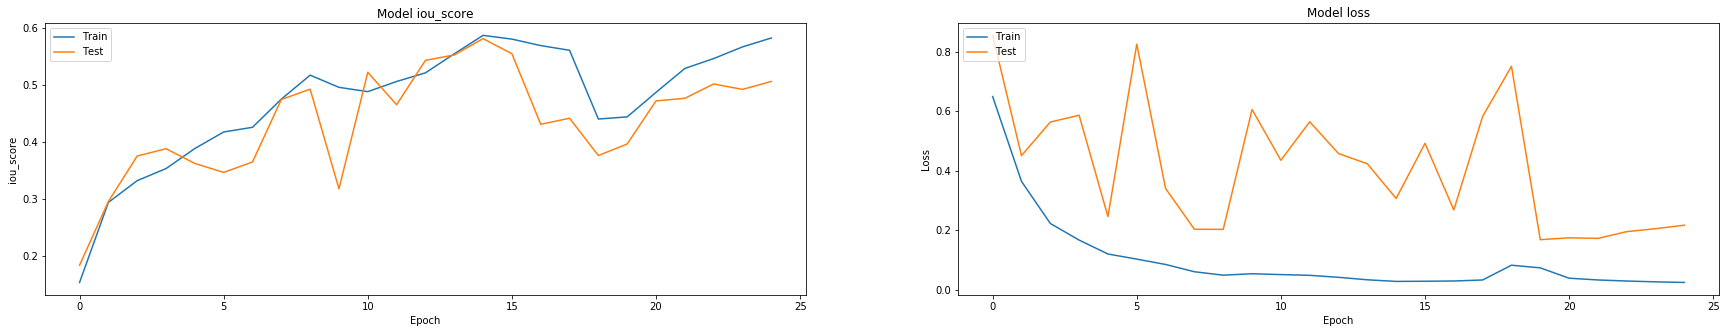

In [81]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

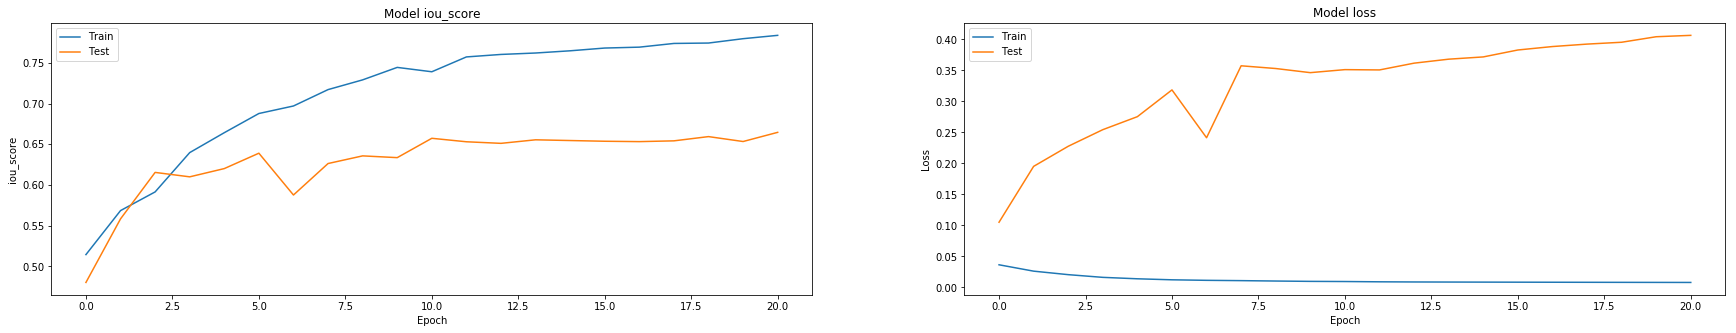

In [82]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history_reload.history['iou_score'])
plt.plot(history_reload.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history_reload.history['loss'])
plt.plot(history_reload.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [83]:
with open(Model_name+'_pt2_history', 'wb') as file_pi:
    pickle.dump(history_reload.history, file_pi)

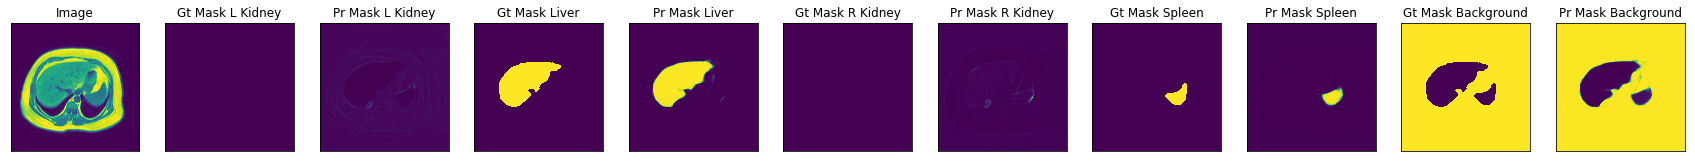

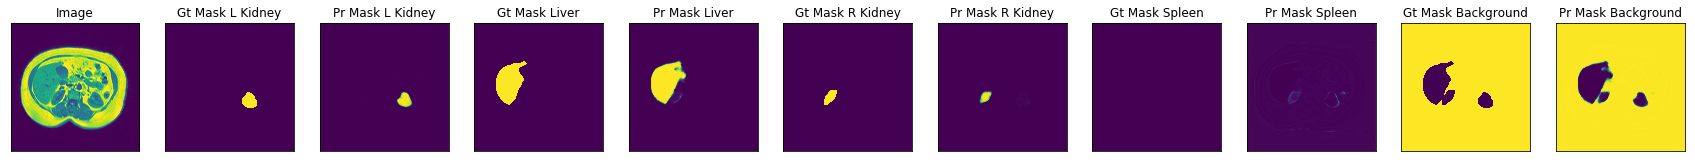

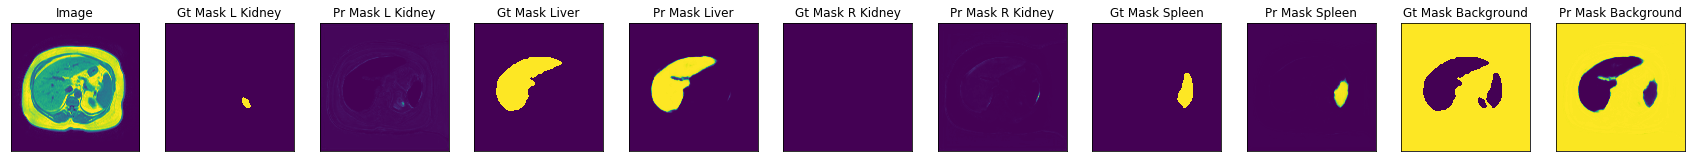

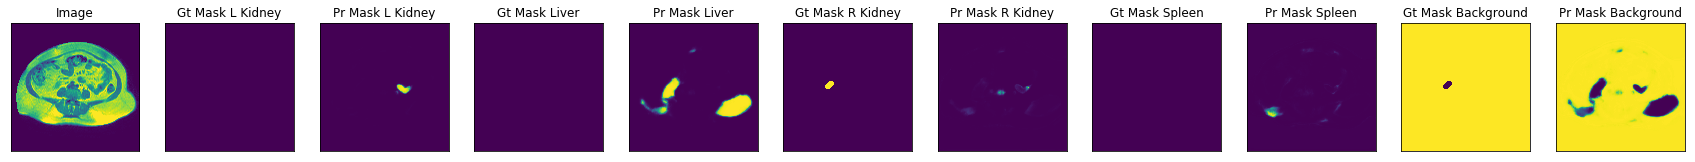

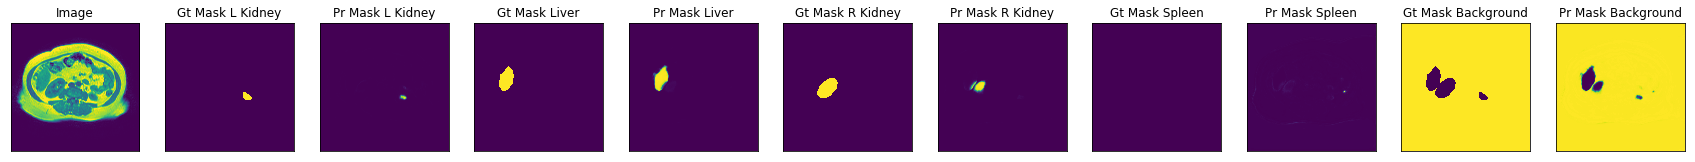

In [31]:
n = 5
import random
random.seed(49)
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    pr_mask_sqz=pr_mask.squeeze()
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask_l_kidney=gt_mask[:,:,0],
        pr_mask_l_kidney=pr_mask_sqz[:,:,0],
        gt_mask_liver=gt_mask[:,:,1],
        pr_mask_liver=pr_mask_sqz[:,:,1],
        gt_mask_r_kidney=gt_mask[:,:,2],
        pr_mask_r_kidney=pr_mask_sqz[:,:,2],
        gt_mask_spleen=gt_mask[:,:,3],
        pr_mask_spleen=pr_mask_sqz[:,:,3],
        gt_mask_background=gt_mask[:,:,4],
        pr_mask_background=pr_mask_sqz[:,:,4],
    )

In [41]:
gt_mask.shape

(512, 512, 5)

In [ ]:
plt.imshow()

In [42]:
pr_mask_sqz=pr_mask.squeeze()
pr_mask_sqz.shape

(512, 512, 5)

In [37]:
image.squeeze().shape

(512, 512)

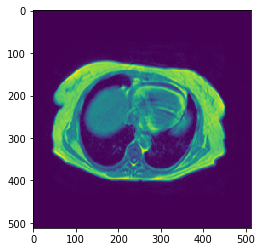

In [34]:
plt.imshow(image.squeeze())


# Model Evaluation

In [32]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

/home/ec2-user/.local/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2567: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [72]:
cd segmentation_models/examples/

/home/ec2-user/SageMaker/segmentation_models/examples


In [73]:
# load best weights
model.load_weights('t1dual_inphase_all_orgs_256greylvl_cls_wghts_yes_adam_opt_Btch_sze_3_softmax_focal_loss.h5') 

In [33]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.021301
mean iou_score: 0.75232
mean f1-score: 0.79394


# Visualization of results on test dataset

28


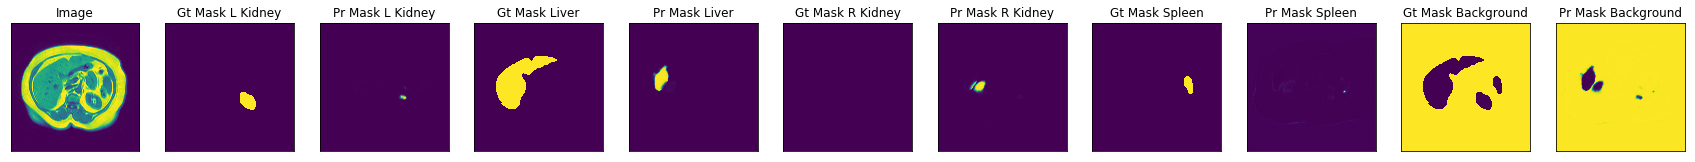

3


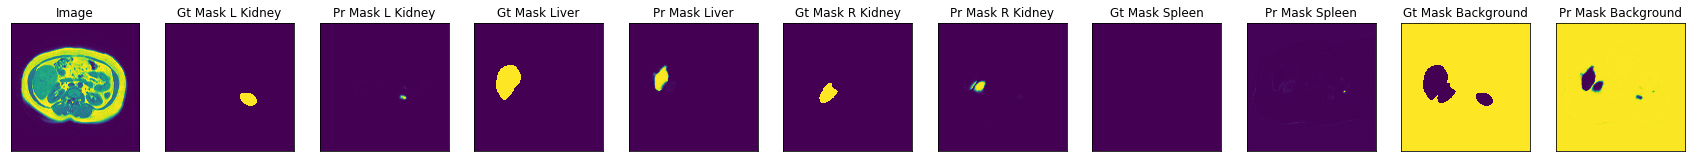

29


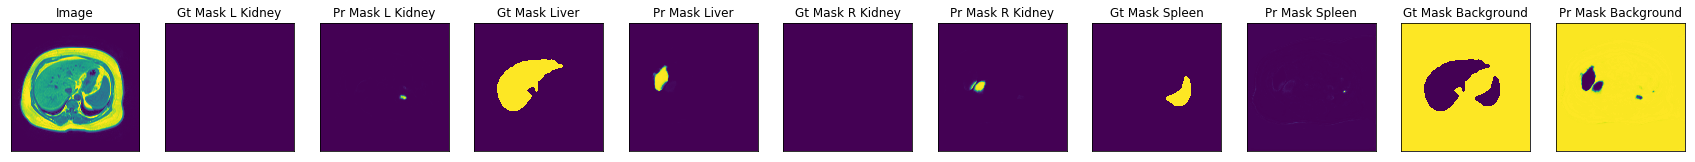

3


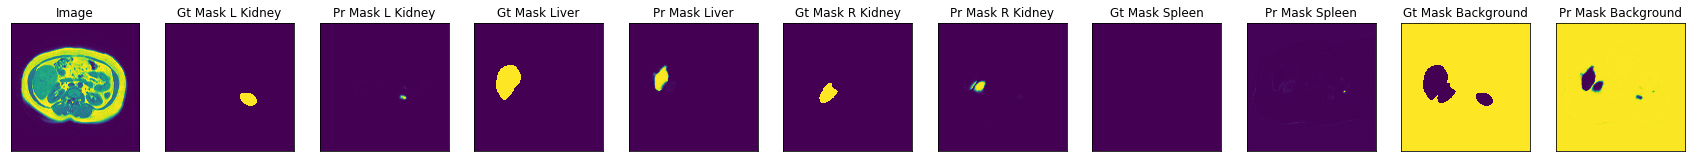

13


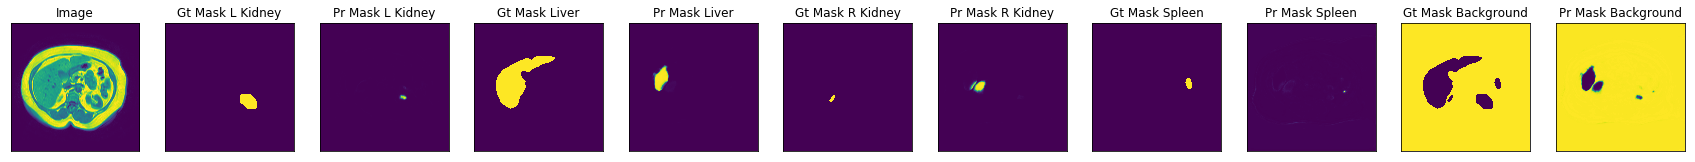

In [37]:
n = 5
import random
random.seed(15)
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    print(i)
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask_l_kidney=gt_mask[:,:,0],
        pr_mask_l_kidney=pr_mask_sqz[:,:,0],
        gt_mask_liver=gt_mask[:,:,1],
        pr_mask_liver=pr_mask_sqz[:,:,1],
        gt_mask_r_kidney=gt_mask[:,:,2],
        pr_mask_r_kidney=pr_mask_sqz[:,:,2],
        gt_mask_spleen=gt_mask[:,:,3],
        pr_mask_spleen=pr_mask_sqz[:,:,3],
        gt_mask_background=gt_mask[:,:,4],
        pr_mask_background=pr_mask_sqz[:,:,4],
    )